In [3]:
import gym
from gym import spaces
import pickle
import pandas as pd
import numpy as np
import random
import tkinter as tk
from tkinter import *
import matplotlib.pyplot as plt
import torch
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from transformers import InformerForPrediction, InformerConfig
import pandas as pd
import numpy as np
import pickle
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler


/Users/yim/opt/anaconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class GRU_update(nn.Module):
    def __init__(self, input_size, hidden_size=1, output_size=4, num_layers=1, prediction_horizon=5, device="cpu"):
        super().__init__()
        self.device = device
        self.h = prediction_horizon
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.mlp = nn.Sequential( nn.ReLU(),
                                  nn.Linear(hidden_size, 2048),
                                  nn.Dropout(0.2),
                                  nn.ReLU(),
                                  nn.Linear(2048, output_size))
        self.hx_fc = nn.Linear(2*hidden_size, hidden_size)

    def forward(self, predicted_values, past_time_features):
        xy = torch.zeros(size=(past_time_features.shape[0], 1, self.output_size)).float().to(self.device)
        hx = past_time_features.reshape(-1, 1, self.hidden_size)
        hx = hx.permute(1, 0, 2)
        out_wp = list()
        for i in range(self.h):
            ins = torch.cat([xy, predicted_values[:, i:i+1, :]], dim=1) # x
            hx, _ = self.gru(ins, hx.contiguous())
            hx = hx.reshape(-1, 2*self.hidden_size)
            hx = self.hx_fc(hx)
            d_xy = self.mlp(hx).reshape(-1, 1, self.output_size) #control v4
            hx = hx.reshape(1, -1, self.hidden_size)
            # print("dxy", d_xy)
            xy = xy + d_xy
            # print("xy plused", xy)
            out_wp.append(xy)
        pred_wp = torch.stack(out_wp, dim=1).squeeze(2)
        return pred_wp

In [5]:
with open('../data/rl_data.pkl', 'rb') as handle:
    rl_data = pickle.load(handle)
with open('../data/minmax_scaler.pkl', 'rb') as handle:
    minmax_scaler = pickle.load(handle)

/Users/yim/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [6]:

        # action_cols = ["SPEED", "HEADING", "MODE"]
        # static_categorical_feature = ["is_weekday", 'direction',"season", "hour"]
        # y_cols = ["FC2", "SOG2"] / ["LATITUDE", "LONGITUDE"]
        # 
        # fc dynamic_real_feature = [ "Time", "SPEED", "HEADING", "MODE", "turn", "acceleration",
        #    'current', 'rain', 'snowfall', 'wind_force', 'wind_direc', "resist_ratio"]
        # loc dynamic_real_feature = [ "Time", "SPEED", "HEADING", "MODE", "turn", "acceleration",
        #    "distance", 'current', 'rain', 'snowfall', 'wind_force', 'wind_direc', "resist_ratio", 
        #    "change_x_factor", "change_y_factor", "FC2", "SOG2"]

        # obs_cols = ["Time2", "turn", "acceleration",
        #    "distance", 'current', 'rain', 'snowfall', 'wind_force', 'wind_direc', "resist_ratio",
        #    'change_x_factor', 'change_y_factor', 
        #    "is_weekday", 'direction', "season", "hour", 
        #    "FC", "SOG", "LATITUDE", 'LONGITUDE',
        #    ],         

In [7]:
class VesselEnvironment(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}
    # model = [tf_loc, gru_loc, tf_fc, gru_fc]
    def __init__(self, rl_data, models=None, scaler=minmax_scaler):
        self.rl_data = rl_data
        self.trip_id = 0
        # load best 1% trips to calculate reward1
        self.hn_top = pd.read_csv("../data/H2N_top1.csv")
        self.nh_top = pd.read_csv("../data/N2H_top1.csv")
        # set scaler
        self.scaler = scaler
        # get device
        if torch.cuda.is_available():
            self.device = torch.device('cuda:0')
        else:
            self.device = torch.device('cpu')
        # load forecasting models
        if models is None:
            self._load_model()
        else:
            self.tf_loc, self.gru_loc, self.tf_fc, self.gru_fc = models
        self._set_eval()

    def _load_model(self):
        # load transformer for longitude latitude prediction
        config_loc = InformerConfig.from_pretrained("huggingface/informer-tourism-monthly", 
                prediction_length=5, context_length=24, input_size=2, num_time_features=1,
                num_dynamic_real_features = 16, num_static_real_features = 4,
                lags_sequence=[1], num_static_categorical_features=0, feature_size=27)
        self.tf_loc = InformerForPrediction(config_loc).to(self.device)
        self.tf_loc.load_state_dict(torch.load("../data/gruloc_3_checkpoint22.pt",
                map_location=torch.device(self.device)))

        # load transformer for fc sog prediction
        config_fc = InformerConfig.from_pretrained("huggingface/informer-tourism-monthly", 
                prediction_length=5, context_length=24, input_size=2, num_time_features=1,
                num_dynamic_real_features = 11, num_static_real_features = 4,
                lags_sequence=[1], num_static_categorical_features=0, feature_size=22)
        self.tf_fc = InformerForPrediction(config_fc).to(self.device)
        self.tf_fc.load_state_dict(torch.load("../data/gru_5_checkpoint16.pt",
                map_location=torch.device(self.device)))

        # load gru models
        self.gru_loc = GRU_update(2, hidden_size=425, output_size=2, num_layers=1, prediction_horizon=5, device=self.device).to(self.device)
        self.gru_fc = GRU_update(2, hidden_size=300, output_size=2, num_layers=1, prediction_horizon=5, device=self.device).to(self.device)
        self.gru_loc.load_state_dict(torch.load("../data/gruloc_3_checkpoint22_gru.pt",
                map_location=torch.device(self.device)))
        self.gru_fc.load_state_dict(torch.load("../data/gru_5_checkpoint16_gru.pt",
                map_location=torch.device(self.device)))
        
    # set to models eval mode
    def _set_eval(self):
        self.gru_fc.eval()
        self.gru_loc.eval()
        self.tf_fc.eval()
        self.tf_loc.eval()

    def _get_observation(self):
        return self.obs[-25:]
    
    def reset(self, seed=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        if(self.trip_id < len(rl_data)-1):
            self.trip_id = self.trip_id + 1
        else:
            self.trip_id = 1

        self.data = self.rl_data[self.trip_id]["observations"]
        self.current_step = 25
        self.obs = self.rl_data[self.trip_id]["observations"][0:25]
        self.actions = self.rl_data[self.trip_id]["actions"][0:25]

        # get direction and other static features
        self.direction = self.rl_data[self.trip_id]["observations"][0, 13]
        self.statics = self.rl_data[self.trip_id]["observations"][0, 12:16]
        if self.direction==1:
            self.top1 = self.hn_top
            self.goal_long, self.goal_lat = np.float64(0.9965111208024382), np.float64(0.7729570345408661)
        else:
            self.top1 = self.nh_top
            self.goal_long, self.goal_lat = np.float64(0.0023259194650222526), np.float64(0)

        # calculate the cumulative reward
        self.reward_cum = 0

        return self._get_observation(), {}

    def _take_action(self, action):
        # get actions
        speed, heading, mode = action
        heading = heading
        mode = int(mode>0.5)
        if self.current_step < self.rl_data[self.trip_id]["observations"].shape[0]:
            future_obs = self.rl_data[self.trip_id]["observations"][self.current_step].copy()
        else:
            future_obs = self.rl_data[self.trip_id]["observations"][-1].copy()
        obs = self._get_observation().copy()

        actions = self.actions[-25:].copy()

        # index of features only used in the fc model
        fc_feature_index = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12]

        # get model inputs
        past_time_features = np.zeros([25, 17])
        past_time_features[:, 0] = obs[:, 0]
        past_time_features[:, 1:4] = actions[:] # speed, heading, mode
        past_time_features[:, 4:15] = obs[:, 1:12]
        past_time_features[:, -2:] = obs[:, 16:18]**2

        future_time_features = past_time_features[-5:].copy()
        future_time_features[:, 0] = future_time_features[:, 0] + 5/120
        future_time_features[0, [1,2,3]] = speed, heading, mode
        future_time_features[0, 4] = heading - past_time_features[-1, 2]
        change_x = np.cos((heading+90) * np.pi / 180)
        change_y = np.sin((heading-90) * np.pi / 180)
        future_time_features[0, [13,14]] = change_x, change_y

        past_values = obs[:, -2:].copy()

        # predict fc, sog, long, lat
        fc2, sog2 = self._predict(past_time_features[:, 15:17], past_time_features[:,fc_feature_index], 
                                  future_time_features[:, fc_feature_index], self.tf_fc, self.gru_fc)
        lat, long = self._predict(past_values, past_time_features, future_time_features, 
                                  self.tf_loc, self.gru_loc)
        fc, sog = min(1, max(0, fc2)**0.5), min(1, max(0, sog2)**0.5)

        # generate next observation and update obs list
        new_observe = future_obs
        new_observe[0] = future_time_features[0, 0]
        new_observe[1:3] = future_time_features[0, 4:6]
        distance = ((self.goal_long-long)**2 + (self.goal_lat-lat)**2 )**0.5
        new_observe[3] = distance
        new_observe[-4:] = fc, sog, lat, long
        # new_observe[-4:] = future_obs[16:19]

        # append new observations and actions
        self.obs = np.append(self.obs, np.expand_dims(new_observe, 0), axis=0)
        self.actions = np.append(self.actions, np.expand_dims(action, 0), axis=0)

        return fc ,sog, lat, long

    def _predict(self, past_values, past_time_features, future_time_features, tf_model, gru_model):
        future_time_features = torch.from_numpy(np.expand_dims(future_time_features, 0)).float().to(self.device)
        past_values = torch.from_numpy(np.expand_dims(past_values, 0)).float().to(self.device)
        past_time_features = torch.from_numpy(np.expand_dims(past_time_features, 0)).float().to(self.device)
        static_real_features = torch.from_numpy(np.expand_dims(self.statics, 0)).float().to(self.device)
        past_observed_mask = torch.ones(past_values.shape).to(self.device)

        # print(past_values.shape, past_time_features.shape, future_time_features.shape)
        # make prediction
        with torch.no_grad():
            outputs = tf_model.generate(past_values=past_values, past_time_features=past_time_features,
                    static_real_features=static_real_features, past_observed_mask=past_observed_mask,
                    future_time_features=future_time_features).sequences.mean(dim=1)
            outputs = gru_model(outputs, past_time_features).detach().cpu().numpy()
        return outputs[0,0,0], outputs[0,0,1]

    def _get_reward(self, long, lat, fc):
        # reward 1 distance to the top 1
        reward1 = - ((long-self.top1.loc[self.current_step, "LONGITUDE"])**2 + (lat-self.top1.loc[self.current_step, "LATITUDE"])**2 )**0.5
        if reward1 > -0.05:
            reward1 = 0
        # reward 2 fc and done reward
        reward2 = -fc
        # reward 3 mimic reward
        if self.current_step < len(self.data):
            reward3 = - ((long-self.data[self.current_step, 19])**2 + (lat-self.data[self.current_step, 18])**2 )**0.5
        else:
            reward3 = - ((long-self.data[-1, 19])**2 + (lat-self.data[-1, 18])**2 )**0.5
        # reward 4 timeout reward
        reward4 = 0
        if self.current_step >= 100:
            reward4 = -0.1*((self.current_step-90)//10)
        return (reward1 + reward2 + reward3 + reward4) / 4

    def step(self, action, test=False):
        obs= self._get_observation()
        self.current_step += 1

        fc, sog, lat, long = self._take_action(action)
        if test:
            return fc, sog, lat, long

        # get done and termination
        done = (((long-self.goal_long)**2 + (lat-self.goal_lat)**2) < 1e-2)
        termination =  self.current_step >= 124

        reward = self._get_reward(long, lat, fc)
        self.reward_cum = self.reward_cum + reward

        if done:
            reward = reward+1
        return obs, reward, done, termination, {}


    def _inv_transform_location(self, lat, long):
        array = np.zeros([1, 12],dtype=np.float64)
        array[0, [7,8]] = lat, long
        lat, long = self.scaler.inverse_transform(array)[0,[7, 8]]
        return lat, long

    def _transform_value(self, vals, indexes):
        array = np.zeros([1, 12],dtype=np.float64)
        for i in range(len(indexes)):
            array[0, indexes[i]] = vals[i]
        transformed_val = self.scaler.transform(array)[0, [indexes]]
        return transformed_val[0]


    def render(self, mode="human"):
        lats, longs = self.obs[:, -2].tolist(), self.obs[:, -1].tolist()
        # for i in range(len(lat)):
            # lat[i], long[i] = self._inv_transform_location(lat[i], long[i])
        
        root = Tk()
        root.title("vessel movement demonstration")

        def draw():
                    
            def _render_step():
                speed, heading, mode = entry1.get(), entry2.get(), entry3.get()
                action = [float(speed), float(heading), float(mode)]
                self.step(action)
                lat, long = self.obs[-1, -2].copy(), self.obs[-1, -1].copy()
                draw()
                lats.append(lat)
                longs.append(long)

            def _reset():
                # TODO: work on reset
                self.reset()
                # lats, longs = self.obs[:, -2].tolist(), self.obs[:, -1].tolist()
                draw()

            canvas = tk.Canvas(root, bg='white', height=420, width=520)
            canvas.place(x=10, y=10)
            for i in range(len(lats)):
                canvas.create_oval(longs[i]*500+10, 380-lats[i]*400, longs[i]*500+15, 380-lats[i]*400+5,)
            canvas.create_oval(longs[-1]*500+10, 380-lats[-1]*400, longs[-1]*500+15, 380-lats[-1]*400+5, fill="red")
            canvas.create_oval(self.goal_long*500+10, 380-self.goal_lat*400, self.goal_long*500+20, 380-self.goal_lat*400+10, fill="green")
            canvas.create_oval(longs[0]*500+10, 380-lats[0]*400, longs[0]*500+20, 380-lats[0]*400+10, fill="green")
            
            canvas.create_text(150, 30, text = "fc: {}".format(self.obs[-1, -4]))
            canvas.create_text(150, 60, text = "sog: {}".format(self.obs[-1, -3]))
            canvas.create_text(150, 90, text = "latitude: {}".format(self.obs[-1, -2]))
            canvas.create_text(150, 120, text = "longitude: {}".format(self.obs[-1, -1]))

            entry1, entry2, entry3 = tk.Entry(root, textvariable = "speed"), tk.Entry(root, textvariable = "heading"), tk.Entry(root,textvariable = "mode" )
            entry1.place(x=10, y=440)
            entry2.place(x=210, y=440)
            entry3.place(x=10, y=480)
            stepBtn = tk.Button(root, text="get next step", width=8, height=1, command=_render_step)
            stepBtn.place(x=430, y=440)

            resetBtn = tk.Button(root, text="reset", width=8, height=1, command=_reset)
            resetBtn.place(x=430, y=480)
        draw()
        root.mainloop()

In [8]:
env = VesselEnvironment(rl_data)
_ = env.reset()

In [35]:
env.render()

In [9]:
# transform_cols = [ 'current', 'rain', 'snowfall', "pressure", 'wind_force', "resist_ratio",
#        'FC', "LATITUDE", 'LONGITUDE', 'SOG', "DEPTH", "SPEED"]
fcs = []
sogs = []
longs = []
lats = []
for i in range(6):
    array = np.zeros((len(rl_data[i]["observations"]), 12))
    array[:, 6] = rl_data[i]["observations"][:, -4]
    array[:, 9] = rl_data[i]["observations"][:, -3]
    array[:, 7] = rl_data[i]["observations"][:, -2]
    array[:, 8] = rl_data[i]["observations"][:, -1]
    # array = minmax_scaler.inverse_transform(array)
    fcs.append(array[:, 6])
    sogs.append(array[:, 9])
    lats.append(array[:, 7])
    longs.append(array[:, 8])

In [10]:
env = VesselEnvironment(rl_data[:7], scaler=minmax_scaler)
env.reset()
fc_predicted = []
sog_predicted = []
lat_predicted = []
long_predicted = []
for i in range(1,7):
    length = rl_data[i]["observations"].shape[0]
    fc = np.zeros((length))
    sog =  np.zeros((length))
    lat = np.zeros((length))
    long = np.zeros((length))
    for j in range(25, length):
        action = rl_data[i]["actions"][j]
        # action[1] = action[1]
        res = env.step(action, test=True)
    #     # print(res)
        fc[j], sog[j], lat[j], long[j] = res[0], res[1], res[2], res[3]
    array1 = np.zeros((length, 12))
    array1[:, 6] = fc
    array1[:, 9] = sog
    array1[:, 7] = lat
    array1[:, 8] = long
    # array1 = minmax_scaler.inverse_transform(array1)
    fc_predicted.append(array1[:, 6])
    sog_predicted.append(array1[:, 9])
    lat_predicted.append(array1[:, 7])
    long_predicted.append(array1[:, 8])
    if(i<6):
        env.reset()


In [11]:
# for i in range(6):
#     length = len(fc_predicted[i])
#     array = np.zeros((length, 10))
#     array[:, 5] = fc_predicted[i]
#     array[:, 6] = lat_predicted[i]
#     array[:, 7] = long_predicted[i]
#     array = minmax_scaler.inverse_transform(array)
#     fc_predicted[i] = (array[:, 5])
#     lat_predicted[i] = (array[:, 6])
#     long_predicted[i] = (array[:, 7])

In [16]:
from  sklearn.metrics import mean_squared_error
plt.rcParams.update({'font.size': 8})

def plot(i):
    fig = plt.figure()
    grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.3)

    ax1 = plt.subplot(grid[0, 0])
    ax2 = plt.subplot(grid[0, 1:])
    ax3 = plt.subplot(grid[1, :1])
    ax4 = plt.subplot(grid[1, 1:])
    mse1 = mean_squared_error(fc_predicted[i][25:], fcs[i+1][25:], squared=False)
    mse2 = mean_squared_error(long_predicted[i][25:], longs[i+1][25:], squared=False)
    mse3 = mean_squared_error(lat_predicted[i][25:], lats[i+1][25:], squared=False)
    mse4 = mean_squared_error(sog_predicted[i][25:], sogs[i+1][25:], squared=False)

    ax1.plot(range(25, len(fc_predicted[i])), fc_predicted[i][25:], label='predictions'.format(i=2))
    ax1.plot(range(25, len(fc_predicted[i])), fcs[i+1][25:], label='actuals'.format(i=1))
    ax1.legend(loc='best')
    ax1.set_title("fc, rmse: {}".format(mse1))
    ax2.plot(range(25, len(fc_predicted[i])), long_predicted[i][25:], label='predictions'.format(i=2))
    ax2.plot(range(25, len(fc_predicted[i])), longs[i+1][25:], label='actuals'.format(i=1))
    ax2.legend(loc='best')
    ax2.set_title("longitude, rmse: {}".format(mse2))
    ax3.plot(range(25, len(fc_predicted[i])), lat_predicted[i][25:], label='predictions'.format(i=2))
    ax3.plot(range(25, len(fc_predicted[i])), lats[i+1][25:], label='actuals'.format(i=1))
    ax3.legend(loc='best')
    ax3.set_title("latitude, rmse: {}".format(mse3))
    ax4.plot(range(25, len(sog_predicted[i])), sog_predicted[i][25:], label='predictions'.format(i=2))
    ax4.plot(range(25, len(sog_predicted[i])), sogs[i+1][25:], label='actuals'.format(i=1))
    ax4.legend(loc='best')
    ax4.set_title("sog, rmse: {}".format(mse4))

    # plt.savefig("env_test_trip{}.jpg".format(i+1))

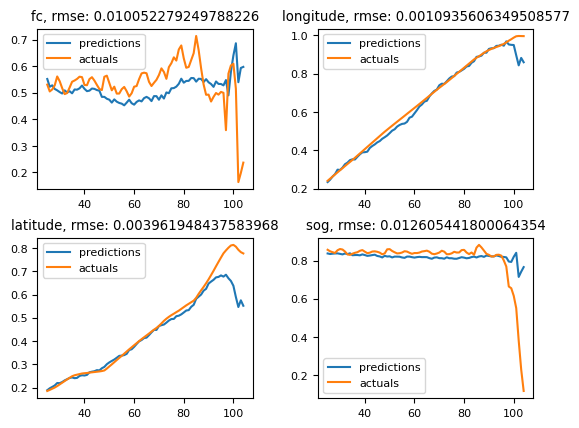

In [17]:
plot(1)